### Processing monthly DePreSys ###

For the first lead time winter (DJF), we want to collate all of the monthly means and perform the standard fidelity testing method, as in Thompson et al. (2017, doi: 10.1038/s41467-017-00275-3).

For both:

* 2m temperature (with a linear detrend/pivot applied)
* 10m winds or 850hPa winds

First we want to fidelity test the meteorological variables:

* 2m temp (UK land mask)
* 10m wind speed (UK wind grid box)
* 850hPa winds (UK wind grid box)

Then we want to quantify the regression relationships between:

1) monthly mean temperature and weather dependent electricity demand.
2) monthly mean wind speed (10m and 850hPa) and total wind generation

Then use these relationships to translate the model met variables into energy variables.

So we can explore the relationship between winter mean conditions and the likelihood of bad seasons in terms of both the mean state and also the likelihood of seeing extremes.

In [1]:
# Local imports
import os
import sys
import time
import argparse
import calendar

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import plot_distributions_fidelity

In [3]:
djf_file_path = '/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/HadGEM3-GC31-MM_tas_United Kingdom_DJF_1960_2018_dcppA-hindcast_Amon.csv'

# check the winters available in this
df = pd.read_csv(djf_file_path)

In [4]:
df.tail()

,init_year,member,lead,data
73745,2018,9,121,279.425814
73746,2018,9,122,275.692171
73747,2018,9,123,275.730993
73748,2018,9,124,278.457006
73749,2018,9,125,277.875223


In [5]:
# import the test file
test_file_path = "/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/tas/HadGEM3-GC31-MM/merged_files/tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1961-r10i1p1f2_gn_196111-197203.nc"

test_cube = iris.load_cube(test_file_path)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(


In [6]:
test_cube.shape

(125, 324, 432)

In [7]:
# Extract the time coordinate
time_coord = test_cube.coord('time')

# Convert the time points to a human-readable format
time_points = time_coord.units.num2date(time_coord.points)

# Print the time values
for time_point in time_points:
    print(time_point)

1961-11-16 00:00:00
1961-12-16 00:00:00
1962-01-16 00:00:00
1962-02-16 00:00:00
1962-03-16 00:00:00
1962-04-16 00:00:00
1962-05-16 00:00:00
1962-06-16 00:00:00
1962-07-16 00:00:00
1962-08-16 00:00:00
1962-09-16 00:00:00
1962-10-16 00:00:00
1962-11-16 00:00:00
1962-12-16 00:00:00
1963-01-16 00:00:00
1963-02-16 00:00:00
1963-03-16 00:00:00
1963-04-16 00:00:00
1963-05-16 00:00:00
1963-06-16 00:00:00
1963-07-16 00:00:00
1963-08-16 00:00:00
1963-09-16 00:00:00
1963-10-16 00:00:00
1963-11-16 00:00:00
1963-12-16 00:00:00
1964-01-16 00:00:00
1964-02-16 00:00:00
1964-03-16 00:00:00
1964-04-16 00:00:00
1964-05-16 00:00:00
1964-06-16 00:00:00
1964-07-16 00:00:00
1964-08-16 00:00:00
1964-09-16 00:00:00
1964-10-16 00:00:00
1964-11-16 00:00:00
1964-12-16 00:00:00
1965-01-16 00:00:00
1965-02-16 00:00:00
1965-03-16 00:00:00
1965-04-16 00:00:00
1965-05-16 00:00:00
1965-06-16 00:00:00
1965-07-16 00:00:00
1965-08-16 00:00:00
1965-09-16 00:00:00
1965-10-16 00:00:00
1965-11-16 00:00:00
1965-12-16 00:00:00


Load in the CANARI data for seasonal testing

In [8]:
# set up canari_years
canari_years = np.arange(1950, 2014 + 1)
canari_period = "HIST2"

# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

In [9]:
# set up the empty dataframe
model_df_full_canari = pd.DataFrame()

# Check that there are csv files for all of the years
# loop ovber the years
for year in tqdm(canari_years):
    # create the fpath
    fpath = os.path.join(output_dir_dfs, f"canari-le-tas-United_Kingdom-{year}-{canari_period}.csv")
    # check if the file exists
    if not os.path.exists(fpath):
        print(f"Missing file for {year}")
        sys.exit()

    # Load the dataframe
    model_df_this = pd.read_csv(fpath)

    # concatenate the dataframes
    model_df_full_canari = pd.concat([model_df_full_canari, model_df_this], ignore_index=True)

100%|██████████| 65/65 [00:09<00:00,  6.55it/s]


In [10]:
# remove the hh:mm:ss from the time
# time is a str
model_df_full_canari['time'] = model_df_full_canari['time'].str.split(" ").str[0]

# subset the canari model data to D, J, F
# where time is a string
# in the format YYYY-MM-DD
model_df_full_canari_djf = model_df_full_canari[model_df_full_canari['time'].str.split("-").str[1].isin(["12", "01", "02"])]

In [42]:
model_df_full_canari_djf.tail()

,member,time,tas,effective_dec_year
935995,40,2014-12-26,276.647215,2014
935996,40,2014-12-27,274.838709,2014
935997,40,2014-12-28,275.233602,2014
935998,40,2014-12-29,275.932057,2014
935999,40,2014-12-30,275.815959,2014


In [41]:
# determine the effective dec year for canari
# Define the custom function to determine the effective_dec_year
def determine_effective_dec_year(row):
    year = int(row["time"].split("-")[0])
    month = row["time"].split("-")[1]
    if month in ["01", "02", "03"]:
        return year - 1
    elif month in ["10", "11", "12"]:
        return year
    else:
        return None  # or some default value if needed

model_df_full_canari_djf["effective_dec_year"] = model_df_full_canari_djf.apply(determine_effective_dec_year, axis=1)

/tmp/ipykernel_3683581/1244228867.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df_full_canari_djf["effective_dec_year"] = model_df_full_canari_djf.apply(determine_effective_dec_year, axis=1)


First DJF winter is lead months 2, 3, and 4. 

In [13]:
# # Subset the dataframe to leads 2, 3, and 4
df_subset = df[df['lead'].isin([2, 3, 4])]

In [14]:
df_subset['lead'].unique()

array([2, 3, 4])

In [15]:
# # Set up a winter years
# winter_years = np.arange(1, 11 + 1)

# # Set up an empty dataframe to store the results
# df_winters = pd.DataFrame()

# # Loop over the winter years
# for i, wyear in enumerate(winter_years):
#     leads_this = np.arange((i * 12) + 2, (i * 12) + 5)

#     # Subset the df to the winter year
#     df_subset = df[df['lead'].isin(leads_this)]

#     # Add a new column for the winter year
#     df_subset['winter_year'] = wyear

#     # concatenate the results
#     df_winters = pd.concat([df_winters, df_subset])

In [16]:
# limit to init years 1960 to 2017
df_subset = df_subset[df_subset['init_year'].isin(range(1960, 2018))]

In [17]:
# set up effective dec year for df_subset
df_subset['effective_dec_year'] = df_subset['init_year'] + 1

In [19]:
df_subset.tail()

,init_year,member,lead,data,effective_dec_year
72252,2017,8,3,279.219407,2018
72253,2017,8,4,280.187978,2018
72376,2017,9,2,279.175587,2018
72377,2017,9,3,280.192167,2018
72378,2017,9,4,279.058393,2018


In [21]:
df_subset["lead"].unique()

array([2, 3, 4])

In [22]:
# # limit the df winters to init years between 1960 and 2017
# df_winters = df_winters[df_winters['init_year'].isin(df_subset["effective_dec_year"].unique())]

In [23]:
# import the obs
obs_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_obs_tas_United Kingdom_DJF_1960_2018.csv"

obs_df = pd.read_csv(obs_path)

In [24]:
obs_df.head()

,time,obs
0,1960-12-01,276.477476
1,1961-01-01,275.904981
2,1961-02-01,279.151625
3,1961-03-01,280.353685
4,1961-04-01,281.654381


In [25]:
# limit obs df between 1960-11-31 and 2018-03-01
obs_df = obs_df[(obs_df['time'] >= '1961-09-30') & (obs_df['time'] <= '2018-04-01')]

In [27]:
# Subset to only include months 12, 1, and 2
obs_df['month'] = pd.DatetimeIndex(obs_df['time']).month

obs_df = obs_df[obs_df['month'].isin([12, 1, 2])]

In [28]:
# ensure that time is a valid datetime
obs_df['time'] = pd.to_datetime(obs_df['time'])

In [29]:
def determine_effective_dec_year(row):
    year = row["time"].year
    month = row["time"].month
    if month in [1, 2, 3]:
        return year - 1
    elif month in [10, 11, 12]:
        return year
    else:
        return None
    
obs_df['effective_dec_year'] = obs_df.apply(determine_effective_dec_year, axis=1)

In [43]:
# print the effective dec years in the obs df
obs_df['effective_dec_year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

In [44]:
model_df_full_canari_djf["effective_dec_year"].unique()

array([1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [32]:
# limit df_subset to the effective dec years in the obs df
df_subset = df_subset[df_subset['effective_dec_year'].isin(obs_df['effective_dec_year'].unique())]

In [45]:
# set up the overlapping years
overlapping_years = np.arange(1961, 2014 + 1)

# apply this to the obs
obs_df_canari = obs_df[obs_df['effective_dec_year'].isin(overlapping_years)]

In [46]:
# apply this to the canari dataset
model_df_full_canari_djf = model_df_full_canari_djf[model_df_full_canari_djf['effective_dec_year'].isin(overlapping_years)]

In [47]:
obs_df_canari.head()

,time,obs,month,effective_dec_year,tas_c
12,1961-12-01,275.360698,12,1961,2.210698
13,1962-01-01,276.763399,1,1961,3.613399
14,1962-02-01,276.684808,2,1961,3.534808
24,1962-12-01,275.352374,12,1962,2.202374
25,1963-01-01,270.720713,1,1962,-2.429287


In [51]:
# Set up time as a datetime in the canari df
# Set up a new column for month in the canari df
def month_col_canari(row):
    return int(row['time'].split("-")[1])

def year_col_canari(row):
    return int(row['time'].split("-")[0])

model_df_full_canari_djf['month'] = model_df_full_canari_djf.apply(month_col_canari, axis=1)
model_df_full_canari_djf['year'] = model_df_full_canari_djf.apply(year_col_canari, axis=1)

In [52]:
model_df_full_canari_djf.head()

,member,time,tas,effective_dec_year,month,year
158730,1,1961-12-01,276.098101,1961,12,1961
158731,1,1961-12-02,275.519401,1961,12,1961
158732,1,1961-12-03,276.424315,1961,12,1961
158733,1,1961-12-04,276.265367,1961,12,1961
158734,1,1961-12-05,275.347797,1961,12,1961


In [75]:
canari_month_averages = pd.DataFrame()

# loop over the unique years in the canari df
for member in model_df_full_canari_djf['member'].unique():
    # subset the df to the member
    model_df_full_canari_djf_this = model_df_full_canari_djf[model_df_full_canari_djf['member'] == member]
    for year in model_df_full_canari_djf['year'].unique():
        # subset the df to the year
        df_this = model_df_full_canari_djf_this[model_df_full_canari_djf_this['year'] == year]

        # loop over the unique months
        for month in df_this['month'].unique():
            # subset the df to the month
            df_this_month = df_this[df_this['month'] == month]

            # calculate the mean
            mean = df_this_month['tas'].mean()

            # append to the dataframe
            # Assuming this is inside a loop where year, month, and mean are defined
            # Append to the dataframe
            df_this_month = pd.DataFrame(
                {
                    "year": [year],
                    "effective_dec_year": [df_this_month['effective_dec_year'].values[0]],
                    "month": [month],
                    "member": [member],
                    "tas": [mean]
                }
            )

            # concat the dataframes
            canari_month_averages = pd.concat([canari_month_averages, df_this_month])
        

In [76]:
canari_month_averages.tail()

,year,effective_dec_year,month,member,tas
0,2013,2012,2,40,274.671354
0,2013,2013,12,40,278.298275
0,2014,2013,1,40,278.057856
0,2014,2013,2,40,274.686830
0,2014,2014,12,40,277.664408


In [77]:
# remove effective dec year 2014
canari_month_averages = canari_month_averages[canari_month_averages['effective_dec_year'] != 2014]

In [78]:
# limit obs_df_canari to the unique effective dec years of the canari dataset
obs_df_canari = obs_df_canari[obs_df_canari['effective_dec_year'].isin(canari_month_averages['effective_dec_year'].unique())]

In [79]:
obs_df_canari.tail()

,time,obs,month,effective_dec_year,tas_c
625,2013-01-01,277.000213,1,2012,3.850213
626,2013-02-01,276.159893,2,2012,3.009893
636,2013-12-01,279.512407,12,2013,6.362407
637,2014-01-01,278.424539,1,2013,5.274539
638,2014-02-01,278.699935,2,2013,5.549935


In [80]:
# convert values from K to c
obs_df['tas_c'] = obs_df['obs'] - 273.15
df["tas_c"] = df["data"] - 273.15
df_subset["tas_c"] = df_subset["data"] - 273.15
canari_month_averages["tas_c"] = canari_month_averages["tas"] - 273.15
# df_winters["tas_c"] = df_winters["data"] - 273.15

#### Fidelity testing ####

Our winter is a 3 month block (DJF).

The observed time series consists of 58 winters * 3 months worth of data.

For the fidelity testing we want to select 58 random winters each times.

Choosing a random year.

And a random ensemble member.

In [81]:
# # subset the obs df to only decembers
# obs_df_dec = obs_df[obs_df['month'] == 2]

# # Subset the model to only decembers
# df_dec = df[df['lead'] == 4]

In [82]:
# # process into seasonal DJF means
# obs_df_seasonal = obs_df.groupby(['effective_dec_year']).mean().reset_index()

In [83]:
# # Set up a new dataframe for the model seasonal means
# df_seasonal = pd.DataFrame()

# # Loop over the unique init years
# for init_year in df['init_year'].unique():
#     for member in df['member'].unique():
#         df_subset = df[(df['init_year'] == init_year) & (df['member'] == member)]
#         # select leads 2, 3, and 4
#         df_subset = df_subset[df_subset['lead'].isin([2, 3, 4])]

#         # calculate the mean
#         mean = df_subset['tas_c'].mean()

#         # create a new df
#         df_new = pd.DataFrame(
#             {
#                 'init_year': [init_year],
#                 'member': [member],
#                 'tas_c': [mean]
#             }
#         )

#         # concatenate the results
#         df_seasonal = pd.concat([df_seasonal, df_new])

In [84]:
# # limit the df_seasonal to init years between 1960 and 2017
# df_seasonal = df_seasonal[df_seasonal['init_year'].isin(range(1960, 2018))]

In [85]:
obs_df["month"].unique()

array([12,  1,  2], dtype=int32)

In [86]:
df_subset.head()

,init_year,member,lead,data,effective_dec_year,tas_c
1,1960,10,2,277.141181,1961,3.991181
2,1960,10,3,277.110962,1961,3.960962
3,1960,10,4,277.857627,1961,4.707627
126,1960,1,2,276.994205,1961,3.844205
127,1960,1,3,277.640137,1961,4.490137


In [87]:
df_subset["lead"].unique()

array([2, 3, 4])

In [88]:
canari_month_averages.head()

,year,effective_dec_year,month,member,tas,tas_c
0,1961,1961,12,1,275.310959,2.160959
0,1962,1961,1,1,276.722277,3.572277
0,1962,1961,2,1,275.362248,2.212248
0,1962,1962,12,1,275.080754,1.930754
0,1963,1962,1,1,271.320066,-1.829934


(array([  1.,   1.,   4.,  15.,  32.,  50., 112., 158., 269., 401., 570.,
        700., 856., 904., 943., 682., 441., 170.,  42.,   9.]),
 array([-4.7178504 , -4.05501338, -3.39217635, -2.72933932, -2.06650229,
        -1.40366526, -0.74082823, -0.0779912 ,  0.58484583,  1.24768286,
         1.91051989,  2.57335692,  3.23619395,  3.89903098,  4.561868  ,
         5.22470503,  5.88754206,  6.55037909,  7.21321612,  7.87605315,
         8.53889018]),
 <BarContainer object of 20 artists>)

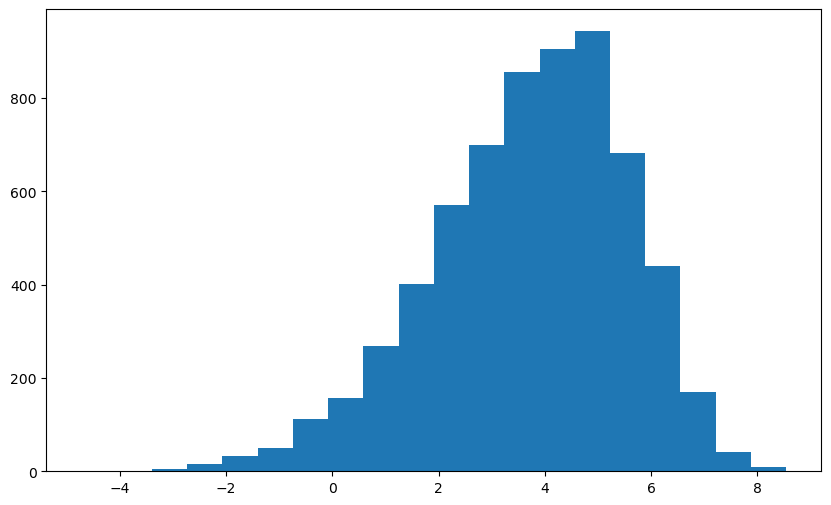

In [89]:
# plot the distribution of canari month averages
fig = plt.figure(figsize=(10, 6))

# plot a histogram of the canari data
plt.hist(canari_month_averages['tas_c'], bins=20)

the number of unique winters is:  53
the unique times are:  [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
Number of days in a model winter: 3
Number of days to resample for: 159
Unique model times [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]


Calculating bootstrap statistics:   0%|          | 9/10000 [00:00<01:59, 83.46it/s]

Calculating bootstrap statistics: 100%|██████████| 10000/10000 [02:00<00:00, 83.03it/s]


(10000,)
shape of obs df obs_val_name:  (159,)


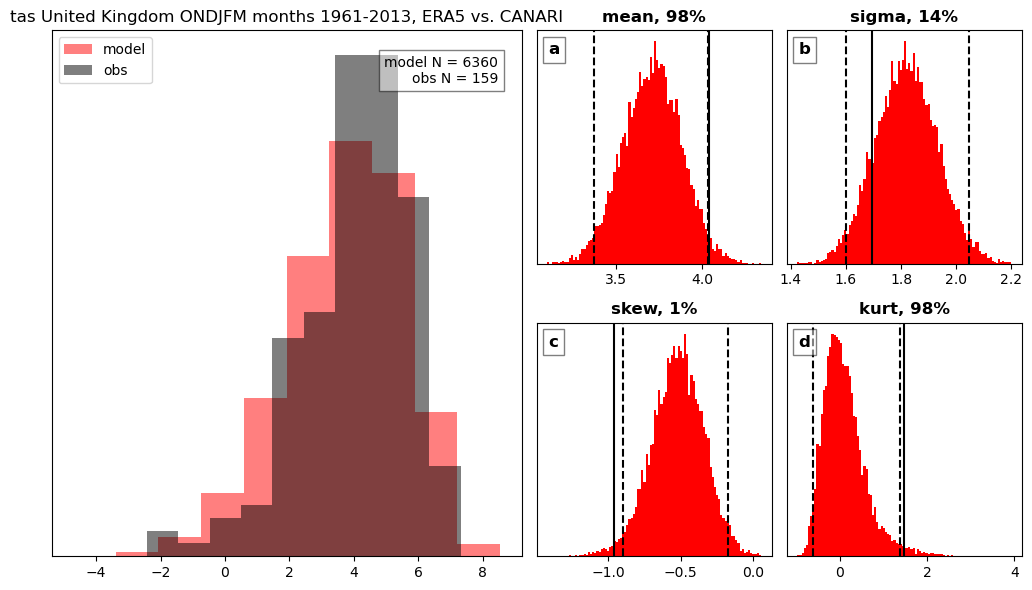

In [91]:
# Plot the distributions and the fidelity
plot_distributions_fidelity(
    obs_df=obs_df_canari,
    model_df=canari_month_averages,
    obs_val_name="tas_c",
    model_val_name="tas_c",
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name=None,
    title="tas United Kingdom ONDJFM months 1961-2013, ERA5 vs. CANARI",
    nboot=10000,
    figsize=(10, 6),
    nbins=40,
    fname_prefix="tas_United_Kingdom_ONDJFM_months_1960_2017_ERA5_vs_CANARI",
)

Potential for multi-model approach here?

In [92]:
test_mpi_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/MPI-ESM1-2-HR_tas_United Kingdom_ONDJFM_1960_2014_dcppA-hindcast_Amon.csv"

# load the df
df_mpi = pd.read_csv(test_mpi_path)

In [99]:
df_mpi.tail()

,init_year,member,lead,data
66858,2014,8,3,276.140122
66859,2014,8,4,277.386598
66979,2014,9,2,279.848348
66980,2014,9,3,275.184070
66981,2014,9,4,275.214489


First DJF in this case is leads 2, 3, 4

In [95]:
# limit to the first 4 leads
df_mpi = df_mpi[df_mpi['lead'].isin([2, 3, 4])]

In [96]:
# print the unique init years
df_mpi['init_year'].unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [98]:
obs_df["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

In [100]:
# Set up the common years
common_years = np.arange(1961, 2014 + 1)

# limit the df_mpi to the common years
df_mpi = df_mpi[df_mpi['init_year'].isin(common_years)]

# limit the obs_df to the common years
obs_df_mpi = obs_df[obs_df['effective_dec_year'].isin(common_years)]

In [102]:
# create a tas_c column in the dataframe
df_mpi["tas_c"] = df_mpi["data"] - 273.15

the number of unique winters is:  54
the unique times are:  [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]
Number of days in a model winter: 3
Number of days to resample for: 162
Unique model times [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]


Calculating bootstrap statistics: 100%|██████████| 10000/10000 [02:01<00:00, 82.23it/s]


(10000,)
shape of obs df obs_val_name:  (162,)


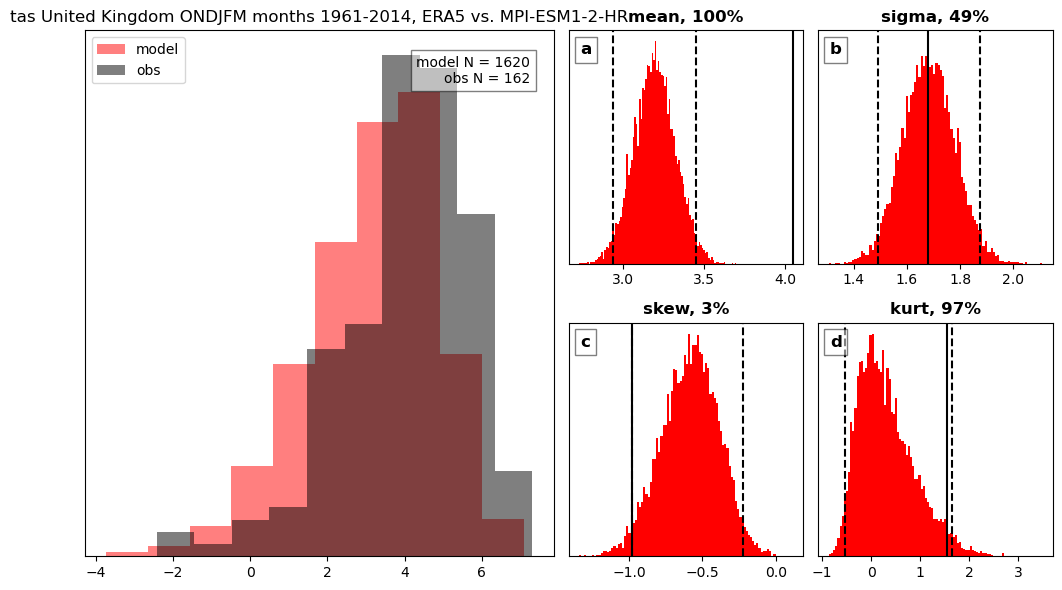

In [103]:
# Plot the distributions and the fidelity
plot_distributions_fidelity(
    obs_df=obs_df_mpi,
    model_df=df_mpi,
    obs_val_name="tas_c",
    model_val_name="tas_c",
    obs_time_name="effective_dec_year",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name=None,
    title="tas United Kingdom ONDJFM months 1961-2014, ERA5 vs. MPI-ESM1-2-HR",
    nboot=10000,
    figsize=(10, 6),
    nbins=40,
    fname_prefix="tas_United_Kingdom_ONDJFM_months_1960_2017_ERA5_vs_CANARI",
)

I guess this isn't regridded to quite the same resolution...

Now try CMCC

In [104]:
cmcc_df_path = '/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/CMCC-CM2-SR5_tas_United Kingdom_ONDJFM_1961_2014_dcppA-hindcast_Amon.csv'

# load the df
df_cmcc = pd.read_csv(cmcc_df_path)

In [106]:
df_cmcc.head()

,init_year,member,lead,data
0,1961,10,1,279.319733
1,1961,10,2,279.062789
2,1961,10,3,278.280338
3,1961,10,4,279.215125
4,1961,10,5,279.663555


In [107]:
# Exract leads 2, 3, and 4
df_cmcc = df_cmcc[df_cmcc['lead'].isin([2, 3, 4])]

In [108]:
# print the unique init years
df_cmcc['init_year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [110]:
# print the unique effective dec years in the obs
obs_df_mpi["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [111]:
# create a new column for tas c
df_cmcc["tas_c"] = df_cmcc["data"] - 273.15

the number of unique winters is:  54
the unique times are:  [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]
Number of days in a model winter: 3
Number of days to resample for: 162
Unique model times [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]


Calculating bootstrap statistics: 100%|██████████| 10000/10000 [02:01<00:00, 82.36it/s]


(10000,)
shape of obs df obs_val_name:  (162,)


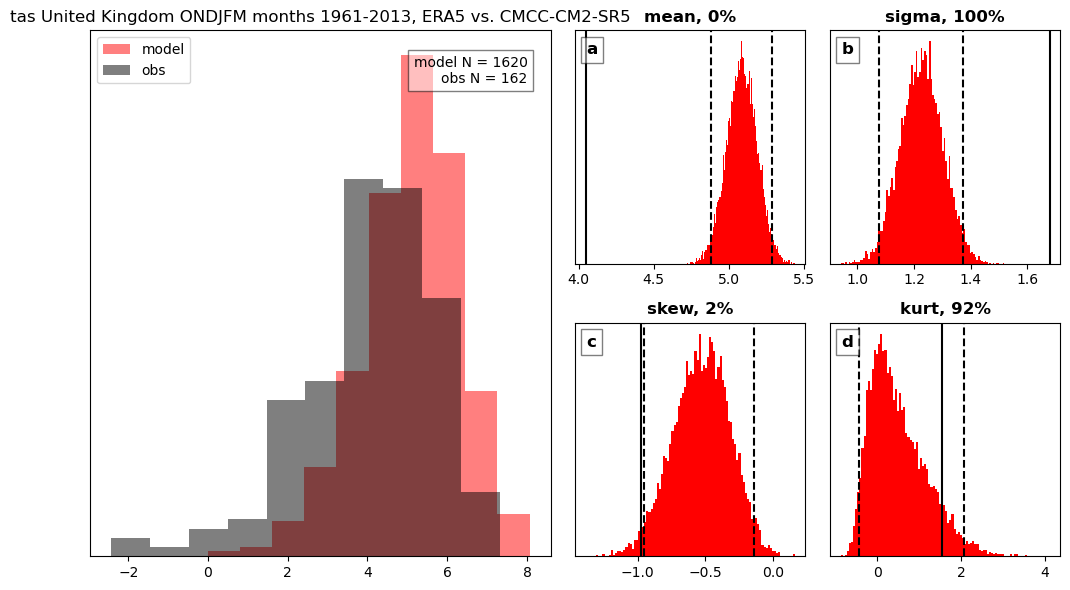

In [112]:
# Plot the distributions and the fidelity
plot_distributions_fidelity(
    obs_df=obs_df_mpi,
    model_df=df_cmcc,
    obs_val_name="tas_c",
    model_val_name="tas_c",
    obs_time_name="effective_dec_year",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name=None,
    title="tas United Kingdom ONDJFM months 1961-2013, ERA5 vs. CMCC-CM2-SR5",
    nboot=10000,
    figsize=(10, 6),
    nbins=40,
    fname_prefix="tas_United_Kingdom_ONDJFM_months_1960_2017_ERA5_vs_CMCC-CM2-SR5",
)

In [113]:
canesm_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/CanESM5_tas_United Kingdom_ONDJFM_1960_2014_dcppA-hindcast_Amon.csv"

# load the df
df_canesm = pd.read_csv(canesm_path)

In [117]:
df_canesm.head()

,init_year,member,lead,data,effective_dec_year
11,1960,10,12,280.743475,1961
12,1960,10,13,278.745654,1961
13,1960,10,14,277.846899,1961
131,1960,11,12,277.978290,1961
132,1960,11,13,277.417078,1961


In [115]:
# extract the specific leads
df_canesm = df_canesm[df_canesm['lead'].isin([12, 13, 14])]

In [116]:
# Set up the effective dec year
df_canesm['effective_dec_year'] = df_canesm['init_year'] + 1

In [118]:
# Set up tas c
df_canesm["tas_c"] = df_canesm["data"] - 273.15

In [119]:
# print the unique effective dec years in the df_canesm
df_canesm["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [124]:
# limit the obs_df to the common years
obs_df_canesm = obs_df[obs_df['effective_dec_year'].isin(df_canesm['effective_dec_year'].unique())]

In [125]:
# # drop effective dec year 2010 from obs_df_canesm
# obs_df_canesm = obs_df_canesm[obs_df_canesm['effective_dec_year'] != 2010]

In [126]:
# remove the 

the number of unique winters is:  55
the unique times are:  [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
Number of days in a model winter: 3
Number of days to resample for: 165
Unique model times [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


Calculating bootstrap statistics:   0%|          | 8/10000 [00:00<02:10, 76.86it/s]

Calculating bootstrap statistics: 100%|██████████| 10000/10000 [02:10<00:00, 76.45it/s]


(10000,)
shape of obs df obs_val_name:  (165,)


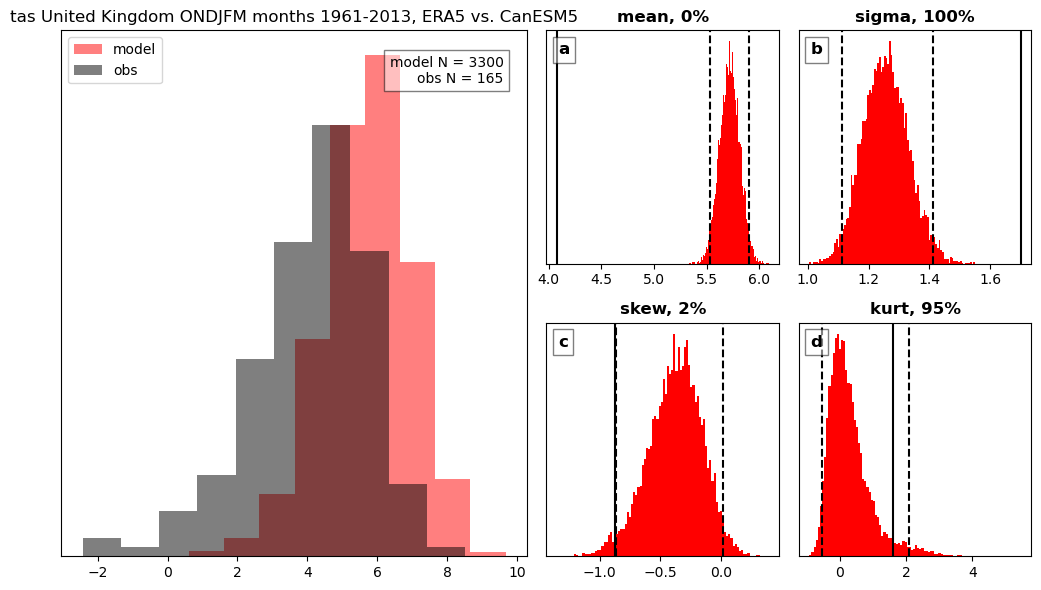

In [127]:
# Plot the distributions and the fidelity
plot_distributions_fidelity(
    obs_df=obs_df_canesm,
    model_df=df_canesm,
    obs_val_name="tas_c",
    model_val_name="tas_c",
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name=None,
    title="tas United Kingdom ONDJFM months 1961-2013, ERA5 vs. CanESM5",
    nboot=10000,
    figsize=(10, 6),
    nbins=40,
    fname_prefix="tas_United_Kingdom_ONDJFM_months_1960_2017_ERA5_vs_CanESM5",
)

In [129]:
cesm_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/CESM1-1-CAM5-CMIP5_tas_United Kingdom_ONDJFM_1960_2017_dcppA-hindcast_Amon.csv"

# load the df
df_cesm = pd.read_csv(cesm_path)



,init_year,member,lead,data
283035,2017,9,118,289.603774
283036,2017,9,119,285.810047
283037,2017,9,120,284.156283
283038,2017,9,121,281.203741
283039,2017,9,122,278.015042


In [130]:
df_cesm["member"].unique()

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  1, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29,  2, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  3, 40,
        4,  5,  6,  7,  8,  9])

In [131]:
# subset to the first leads
df_cesm = df_cesm[df_cesm['lead'].isin([2, 3, 4])]

In [132]:
# process the tas_c
df_cesm["tas_c"] = df_cesm["data"] - 273.15

In [133]:
# print the unique init years
df_cesm['init_year'].unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017])

In [134]:
obs_df["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

In [135]:
# limit the df_cesm to the yars in the obs
df_cesm = df_cesm[df_cesm['init_year'].isin(obs_df["effective_dec_year"].unique())]

the number of unique winters is:  57
the unique times are:  [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
Number of days in a model winter: 3
Number of days to resample for: 171
Unique model times [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]


Calculating bootstrap statistics: 100%|██████████| 10000/10000 [02:10<00:00, 76.90it/s]


(10000,)
shape of obs df obs_val_name:  (171,)


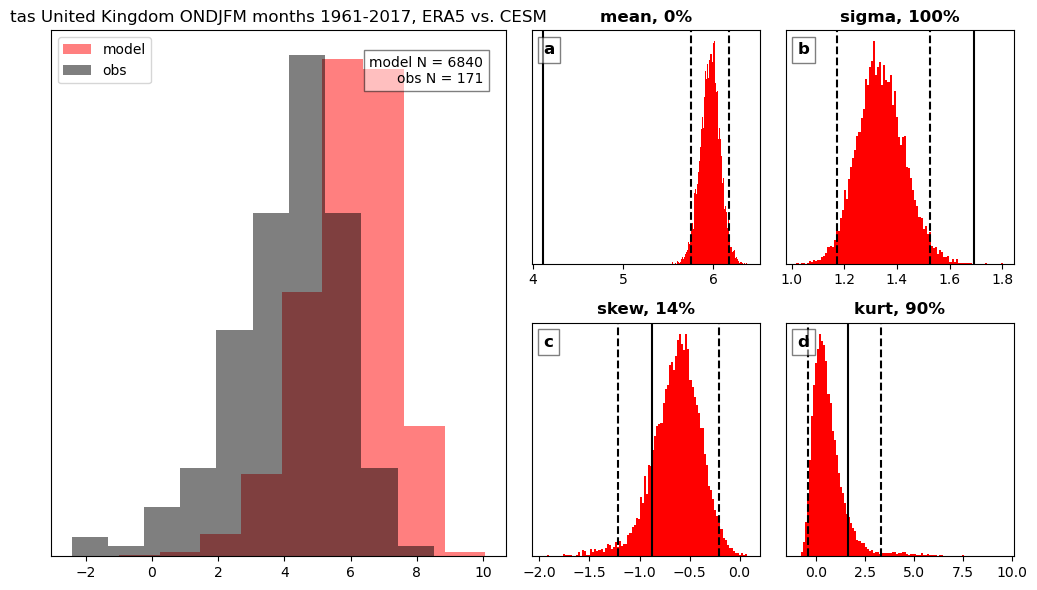

In [136]:
# Plot the distributions and the fidelity
plot_distributions_fidelity(
    obs_df=obs_df,
    model_df=df_cesm,
    obs_val_name="tas_c",
    model_val_name="tas_c",
    obs_time_name="effective_dec_year",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name=None,
    title="tas United Kingdom ONDJFM months 1961-2017, ERA5 vs. CESM",
    nboot=10000,
    figsize=(10, 6),
    nbins=40,
    fname_prefix="tas_United_Kingdom_ONDJFM_months_1960_2017_ERA5_vs_CESM",
)

In [137]:
bcc_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/BCC-CSM2-MR_tas_United Kingdom_ONDJFM_1961_2014_dcppA-hindcast_Amon.csv"

# load the bcc data
df_bcc = pd.read_csv(bcc_path)

In [138]:
# select the first leads
df_bcc = df_bcc[df_bcc['lead'].isin([2, 3, 4])]

In [139]:
# create the tas column
df_bcc["tas_c"] = df_bcc["data"] - 273.15

In [140]:
# print the unique init years
df_bcc['init_year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [141]:
# print the unique effective dec years in the obs
obs_df["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

In [142]:
obs_df_bcc = obs_df[obs_df['effective_dec_year'].isin(df_bcc['init_year'].unique())]

the number of unique winters is:  54
the unique times are:  [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]
Number of days in a model winter: 3
Number of days to resample for: 162
Unique model times [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]


Calculating bootstrap statistics: 100%|██████████| 10000/10000 [02:01<00:00, 82.55it/s]


(10000,)
shape of obs df obs_val_name:  (162,)


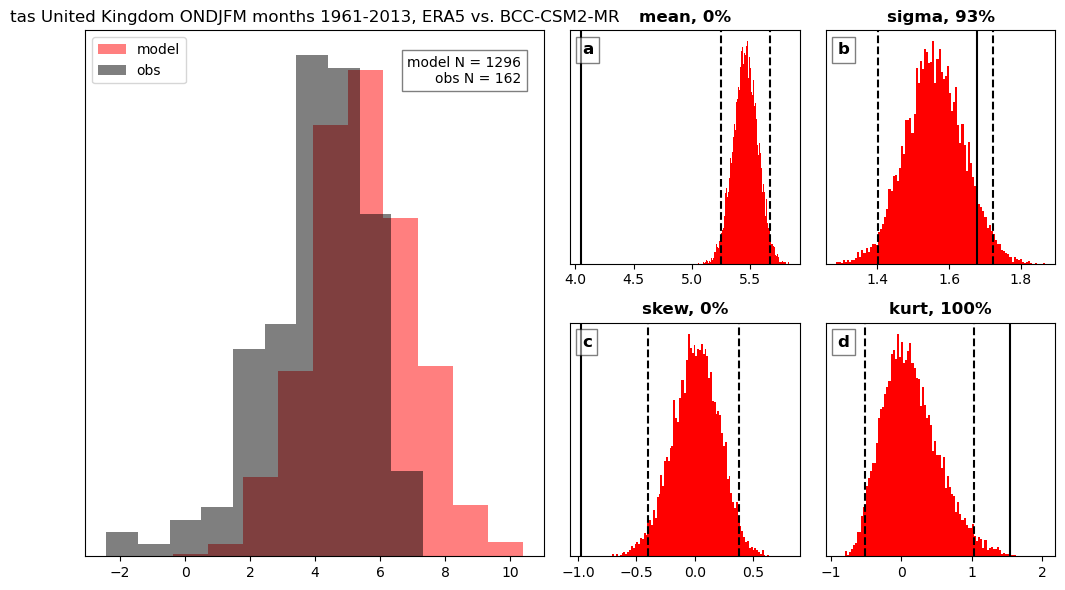

In [143]:
# Plot the distributions and the fidelity
plot_distributions_fidelity(
    obs_df=obs_df_bcc,
    model_df=df_bcc,
    obs_val_name="tas_c",
    model_val_name="tas_c",
    obs_time_name="effective_dec_year",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name=None,
    title="tas United Kingdom ONDJFM months 1961-2013, ERA5 vs. BCC-CSM2-MR",
    nboot=10000,
    figsize=(10, 6),
    nbins=40,
    fname_prefix="tas_United_Kingdom_ONDJFM_months_1960_2017_ERA5_vs_BCC-CSM2-MR",
)